# Кластеризация 







## 2. Боевая задача! 

Представим, что международное круизное агентство "Carnival Cruise Line" решило себя разрекламировать с помощью баннеров и обратилось для этого к Вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с Вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры - легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях - Foursqare. Часть открытых данных есть, например, на сайте [archive.org.](https://archive.org/details/201309_foursquare_dataset_umn) Нас будет интересовать файл `checkins.dat`. Подгрузим его и посмотрим, что лежит внутри. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('checkins.csv')
df.head()

,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


In [3]:
df.shape

(396634, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396634 entries, 0 to 396633
Data columns (total 6 columns):
id            396634 non-null int64
user_id       396634 non-null float64
venue_id      396634 non-null float64
latitude      396634 non-null float64
longitude     396634 non-null float64
created_at    396634 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 18.2+ MB


In [5]:
X = df[['longitude', 'latitude']]
X.head()

,longitude,latitude
0,-77.036366,38.895112
1,-84.410520,33.800745
2,-122.676207,45.523452
3,-111.904565,40.764462
4,-112.074037,33.448377


Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу "Carnival Cruise Line" адреса офисов:

```
33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)
```

In [6]:
ofices = np.array([[-118.188740, 33.751277],[-80.324116, 25.867736], [-0.075479, 51.503016],
                  [4.885084, 52.378894], [117.036146, 39.366487], [151.205134, -33.868457]])

Посмотрим как расположение офисов и чекпойнтов выглядит на картинке и попробуем догадаться где какой материк.

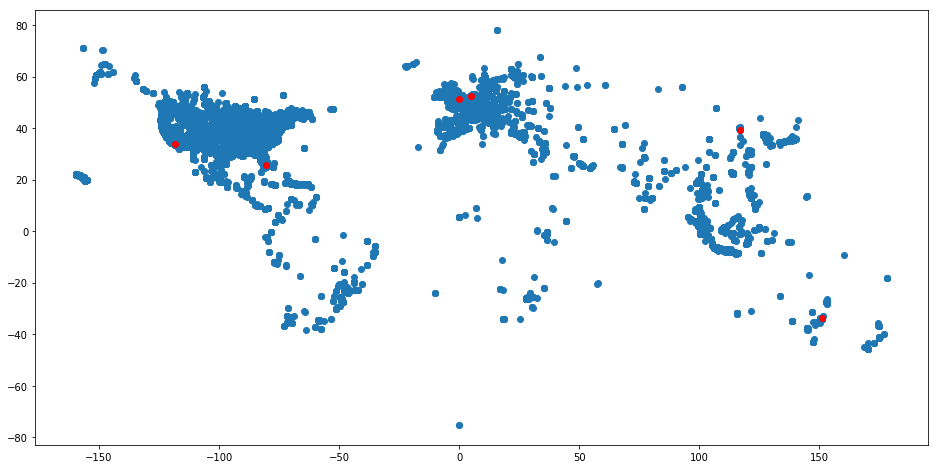

In [7]:
plt.figure(figsize=(16,8))
plt.scatter(X.longitude.values,X.latitude.values)
plt.scatter(ofices[:,0], ofices[:,1], color='red')

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Примечание**: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико, чтобы не повлиять на кластеризацию или сортировку.

In [ ]:
X.latitude.values[:10]

In [ ]:
X[:10].get_values()

Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров. И такой алгоритм, действительно есть! Он называется `MeanShift`. Его описание при желании можно посмотреть в [sklearn user guide.](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

В этом алгоритме можно искуственно ограничить радиус каждого кластера с помощью специальной опции `bandwidth`. Укажем `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

**Примечание**: на 396632 строках, кластеризация будет работать долго. Для получения корректного ответа достаточно и 100000 (~2 минуты на "среднем" ноутбуке). Быть очень терпеливым не возбраняется - результат от этого только улучшится.

In [8]:
%%time
from sklearn import cluster
clt = cluster.MeanShift(bandwidth=0.1, bin_seeding=True, min_bin_freq=15)
clt.fit(X)

CPU times: user 21.2 s, sys: 261 ms, total: 21.5 s
Wall time: 27.8 s


Посмотрим сколько всего кластеров выделила модель. Сохраним координаты всех центров в отдельный вектор. 

In [9]:
len(clt.cluster_centers_)

1170

In [10]:
centers = clt.cluster_centers_
centers

array([[ -73.98935883,   40.71748459],
       [ -87.6298271 ,   41.87816455],
       [-111.90253317,   33.44682809],
       ...,
       [ -82.2945923 ,   38.4095298 ],
       [ -89.2673    ,   48.415802  ],
       [ -86.2736407 ,   42.4030865 ]])

Посмотрим на то как центры кластеров выглядят на карте мира! Код ниже тут находится исключительно для построения красивой картинки. Если он вам покажется сложным, можете не разбираться в нём :) 

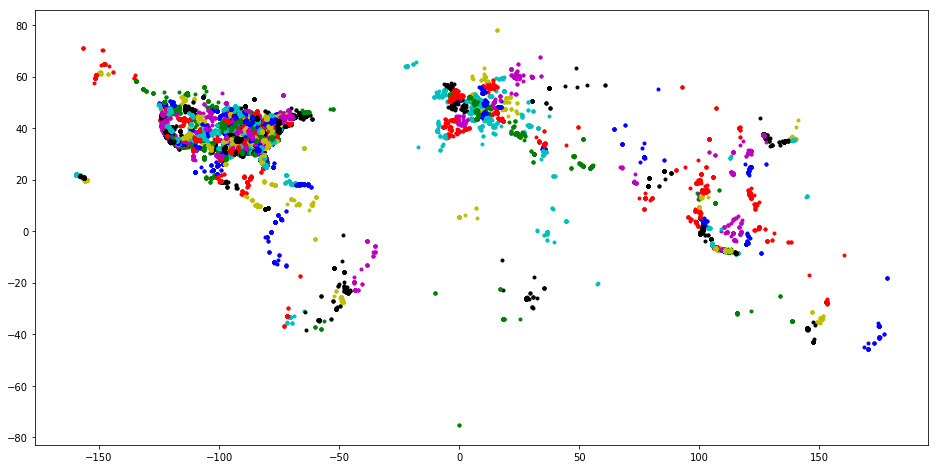

In [11]:
from itertools import cycle

labels = clt.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(16,8))

# Будем перебирать все цвета внутри вот этого цикла
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X.values[my_members,0],X.values[my_members,1],col + '.' )

Можно построить точно такую же картинку, но ещё и с центрами кластеров.

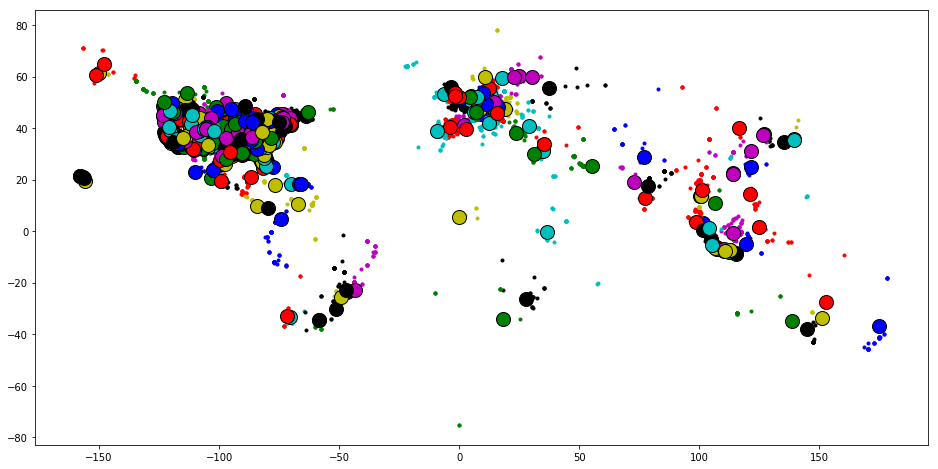

In [12]:
plt.figure(figsize=(16,8))

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X.values[my_members,0],X.values[my_members,1],col + '.' )
    
    # Выделяем у кластеров центры 
    plt.plot(center[0], center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

Мы немного отвлеклись на картинки. Давайте вернёмся к нашей задаче. Мы должны выбрать 20 самых близких к офисам точек с самой высокой просматриваемостью. Давайте найдём такие точки. Для этого отсортируем центры кластеров по расстояниям до каждого офиса. 

In [13]:
results = [ ]
for item in ofices:
    for jtem in centers:
        cur_rast = float(np.linalg.norm(jtem - item, ord=2))
        trio = (cur_rast,jtem,item)
        results.append(trio)

In [14]:
results[0]

(44.74498121705711,
 array([-73.98935883,  40.71748459]),
 array([-118.18874 ,   33.751277]))

In [15]:
len(centers)*6

7020

In [16]:
len(results)

7020

И возьмём 20 самых близких офисов

In [17]:
results.sort()
best_20 = results[:20]

best_20[:5]

[(0.003022703449948845,
  array([151.20708242, -33.86614607]),
  array([151.205134, -33.868457])),
 (0.009624603275668695,
  array([ 4.89226825, 52.37248935]),
  array([ 4.885084, 52.378894])),
 (0.03933862258791184,
  array([-80.29771155,  25.89689645]),
  array([-80.324116,  25.867736])),
 (0.05163441574703833,
  array([-0.1271134 , 51.50305542]),
  array([-0.075479, 51.503016])),
 (0.07464357860975084,
  array([-118.14433437,   33.81127536]),
  array([-118.18874 ,   33.751277]))]

In [18]:
# Распакуем координаты для строительства картинки 
coord = np.array([[item[1][0],item[1][1]] for item in best_20])

Строим ещё картинку! 

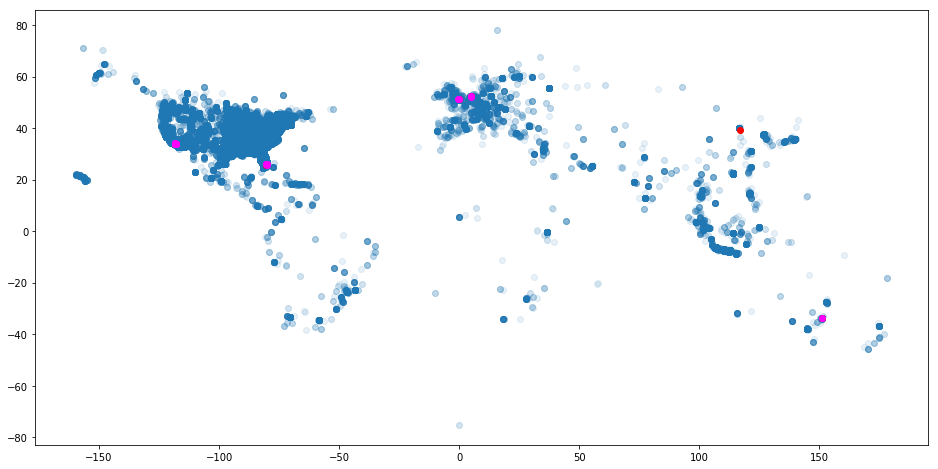

In [19]:
plt.figure(figsize=(16,8))
plt.scatter(X.longitude.values,X.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(ofices[:,0], ofices[:,1], color='red')            # Наносим офисы 
plt.scatter(coord[:,0], coord[:,1], color='magenta')          # Наносим точки для рекламы 

Посмотрим в окрестностях какого офиса оказалась большая часть баннеров.

Добро пожаловать в Калифорнию, детка!

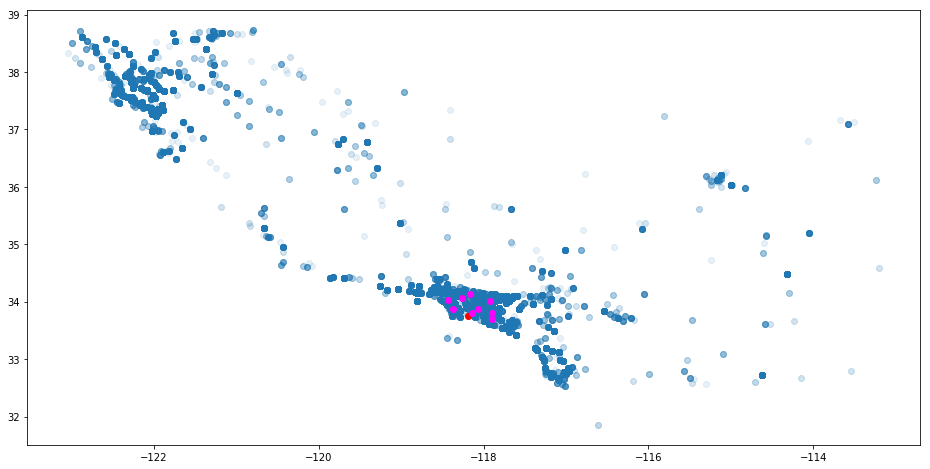

In [37]:
l = 5
с_long = -118.18874
c_lat = 33.751277

X_int = X[(X.longitude > с_long - l)&(X.longitude < с_long + l)& 
          (X.latitude >  - l)&(X.latitude < c_lat + l)]
    
coord_int = coord[(coord[:,0] > с_long - l)&(coord[:,0] < с_long + l)& 
                  (coord[:,1] > c_lat - l)&(coord[:,1] < c_lat + l)]    


ofices_int = ofices[(ofices[:,0] > с_long - l)&(ofices[:,0] < с_long + l)& 
                    (ofices[:,1] > c_lat - l)&(ofices[:,1] < c_lat + l)] 

plt.figure(figsize=(16,8))
plt.scatter(X_int.longitude.values,X_int.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(ofices_int[:,0], ofices_int[:,1], color='red')            # Наносим офисы 
plt.scatter(coord_int[:,0], coord_int[:,1], color='magenta')          # Наносим точки для рекламы 